In [8]:
# Application
import imutils
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import tensorflow as tf
import string
from keras.utils import np_utils

In [9]:
model = load_model("letter_number_cnn.h5")

In [10]:
# https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/
# https://stackoverflow.com/questions/56698714/how-to-segment-characters-and-words-from-images-into-contours
# https://www.kaggle.com/code/aman10kr/offline-handwritten-text-ocr/notebook
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)
def get_word(img):
    word_image_list = []
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=5)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="top-to-bottom")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        word_image_list.append(roi)
    plt.imshow(image)
    return word_image_list

1/1 [==============================] - 0s 12ms/step
['111', 'PLATELET', '222', 'ALBUMIN']


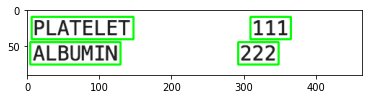

In [11]:
def image_to_text(create_image, image_size=128):
  # Reshape image
  reshape_image = cv2.resize(create_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
  # Normalizing the dataset
  reshape_image = tf.keras.utils.normalize(reshape_image, axis=1)
  # Put the color channel to the dimension
  reshape_image = np.array(reshape_image).reshape(-1, image_size, image_size, 1)
  prediction = model.predict(reshape_image)
  labels = list(range(0, 10)) + list(string.ascii_uppercase)
  return labels[np.argmax(prediction[0]) - 1]
# https://stackoverflow.com/questions/36255654/how-to-add-border-around-an-image-in-opencv-python
def enlarge_image(im, bordersize = 3):
  row, col = im.shape[:2]
  bottom = im[row-2:row, 0:col]
  mean = cv2.mean(bottom)[0]

  border = cv2.copyMakeBorder(
      im,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_CONSTANT,
      value=[255, 255, 255]
  )

  return border
# # https://stackoverflow.com/questions/60515216/extracting-and-saving-characters-from-an-image
# Load image, grayscale, Otsu's threshold
word_image_list = get_word("medical record.png")
context_list = []
for image in word_image_list:
  thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

  # Find contours, sort from left-to-right, then crop
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts, _ = contours.sort_contours(cnts, method="left-to-right")

  # Filter using contour area and extract ROI
  ROI_number = 0
  text_list = []
  for c in cnts:
      area = cv2.contourArea(c)
      if area > 10:
          x,y,w,h = cv2.boundingRect(c)
          ROI = image[y:y+h, x:x+w]
          large_image = enlarge_image(ROI)
          text = image_to_text(large_image)
          text_list.append(text)
          cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
          ROI_number += 1
  context_list.append("".join([str(element) for element in text_list]))
print(context_list)